# U-Net cell segmentation on the DIC-C2DH-HeLa dataset

## Import modules

In [3]:
from PIL import Image
from skimage.measure import label
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import gc, os

In [4]:
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds

In [5]:
from unet.utils import UNetHelper
from unet.losses import IoU, dice_loss, unet_sample_weights
from unet.augmentation import elastic_deformation, grid_deformation

I0000 00:00:1754503500.986878 1224702 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21770 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


In [6]:
tf.get_logger().setLevel('ERROR')

# Notebook configuration

In [7]:
train_model = True
tf_dir = "TFData"
batch_size = 8
max_epochs = 280

In [8]:
os.system(f"mkdir -p {tf_dir}/TFCache {tf_dir}/models")

0

## Random seed

For resetting the seed when running the training loop multiple times

In [9]:
reset_seed = lambda seed=42: tf.keras.utils.set_random_seed(seed)
reset_seed()

## Distributed training strategy

This selection is based off the tools I have at my disposal: either 1 GPU at work or 2 on Kaggle

In [10]:
gpus = len(tf.config.list_physical_devices("GPU"))

if gpus <= 1: 
    strategy = tf.distribute.OneDeviceStrategy(device="/GPU:0")
else: 
    strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.ReductionToOneDevice())

n_devices = strategy.num_replicas_in_sync
print(f"Using {n_devices} device(s).")
print(f"Using {strategy.__class__.__name__}.")

Using 1 device(s).
Using OneDeviceStrategy.


# Load the dataset

In [11]:
def process_img(img, mask):
    """
    Contrast Limited Adaptive Histogram Equalization (CLAHE) step, 
    followed by sample weight calculation [0.0, 1.0] normalization. 
    CLAHE uses the default OpenCV parameters.
    """
    clh = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clh_img = clh.apply(np.squeeze(img.numpy())) 
    sample_weights = unet_sample_weights(mask.numpy(), data_type=np.float32)
    return (tf.constant(np.expand_dims(clh_img / 255.0, -1), dtype=tf.float32, shape=img.get_shape()), 
            mask,
            tf.constant(sample_weights, dtype=tf.float32, shape=mask.get_shape()))

In [12]:
def min_max(arr):
    arr = np.asarray(arr)
    minimum, maximum = arr.min(), arr.max()
    return (arr - minimum) / (maximum - minimum)

In [13]:
img_shape = (512, 512, 1)
mask_shape = (512, 512)

hela_train = tfds.load("hela_train", data_dir=tf_dir)

# Cache CLAHE-equalized images
# ensure_shape step needed for graph execution

# Cache segment 01
hela_train["01"] = hela_train["01"].map(lambda sample: tf.py_function(process_img, inp=[sample['image'], sample['mask']], 
                                                                      Tout=[tf.float32, tf.int32, tf.float32]),  
                                        num_parallel_calls=tf.data.AUTOTUNE)\
                                   .map(lambda X, y, sw: (tf.ensure_shape(X, img_shape), 
                                                          tf.ensure_shape(y, mask_shape), 
                                                          tf.ensure_shape(sw, mask_shape)))\
                                   .cache(f"{tf_dir}/TFCache/01_CLAHE_NORM")
example = list(hela_train["01"].take(2))

# Cache segment 02
hela_train["02"] = hela_train["02"].map(lambda pair: tf.py_function(process_img, inp=[pair['image'], pair['mask']], 
                                                                    Tout=[tf.float32, tf.int32, tf.float32]),  
                                        num_parallel_calls=tf.data.AUTOTUNE)\
                                   .map(lambda X, y, sw: (tf.ensure_shape(X, img_shape), 
                                                          tf.ensure_shape(y, mask_shape), 
                                                          tf.ensure_shape(sw, mask_shape)))\
                                   .cache(f"{tf_dir}/TFCache/02_CLAHE_NORM")
example += list(hela_train["02"].take(2))

2025-08-06 15:05:02.640792: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-06 15:05:02.752407: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


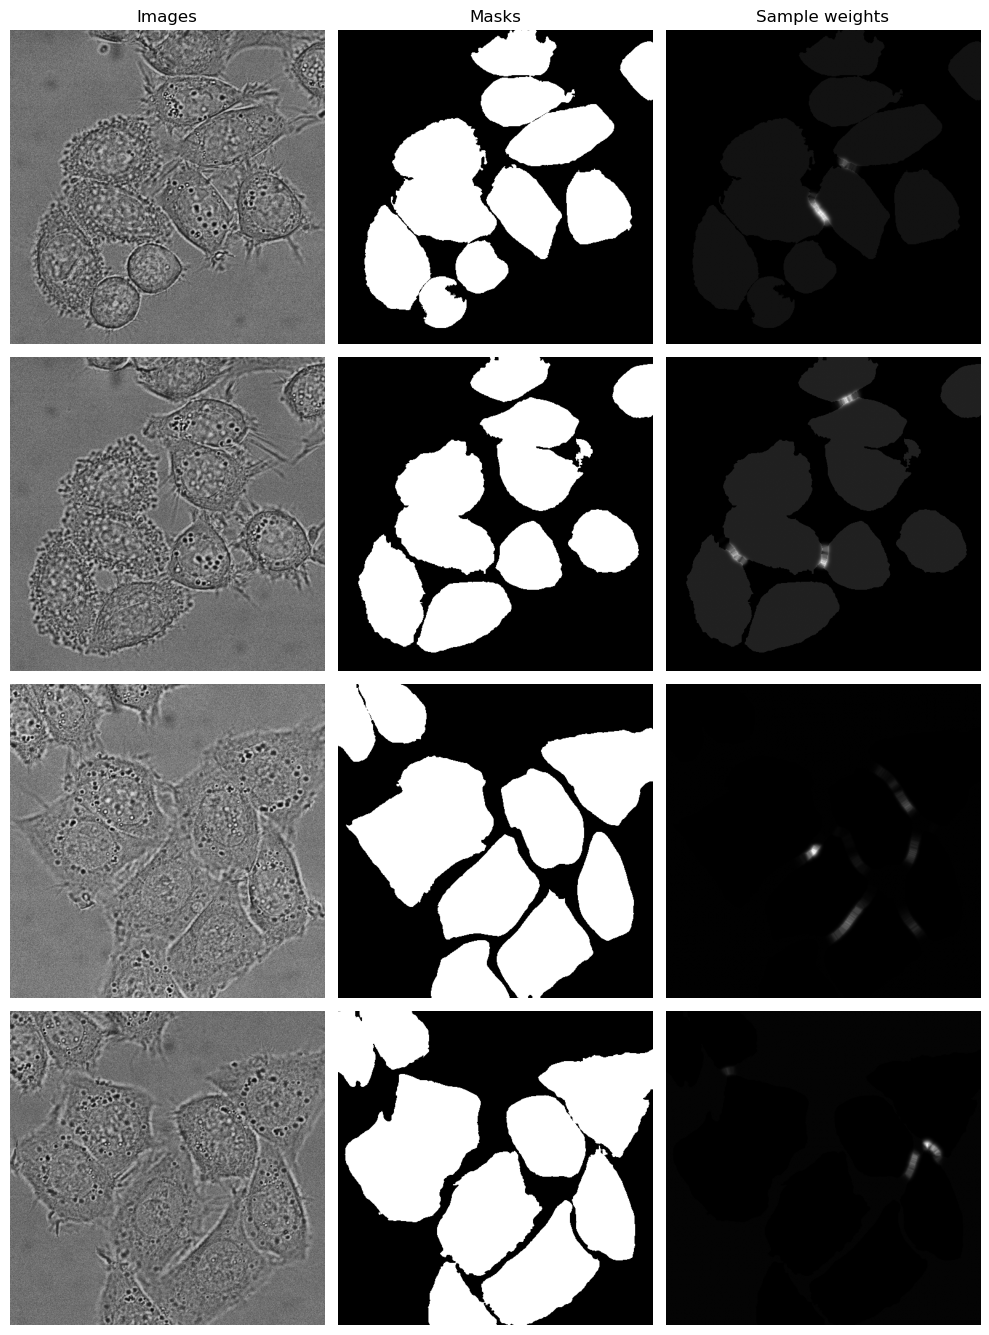

In [14]:
fig, axes = plt.subplots(len(example), 3, figsize=(10, 5 * len(example)))

axes[0,0].set_title("Images")
axes[0,1].set_title("Masks")
axes[0,2].set_title("Sample weights")

for row, ex in zip(axes, example):
    for ax, img in zip(row, ex):
        ax.imshow(min_max(img), cmap="gray")
        ax.axis("off")
        ax.set_aspect('equal')

fig.tight_layout(h_pad=-40, w_pad=1)
plt.show()

# Data augmentation

In [15]:
@tf.function
def pipeline(X, y, w):
    # Add channel axis
    y = tf.expand_dims(y, axis=-1)
    w = tf.expand_dims(w, axis=-1)
    # Horizontal flip
    if tf.random.uniform((), 0.0, 1.0) >= 0.5:
        X = tf.image.flip_left_right(X)
        y = tf.image.flip_left_right(y)
        w = tf.image.flip_left_right(w)
    # Vertical flip
    if tf.random.uniform((), 0.0, 1.0) >= 0.5:
        X = tf.image.flip_up_down(X)
        y = tf.image.flip_up_down(y)
        w = tf.image.flip_up_down(w)
    # Grid deformation
    if tf.random.uniform((), 0.0, 1.0) >= 0.5:
        grid_size = 5
        distort_limits = (-0.35, 0.35)
        X = grid_deformation(X, distort_limits=distort_limits, grid_size=grid_size, order=1)
        y = grid_deformation(y, distort_limits=distort_limits, grid_size=grid_size, order=0)
        w = grid_deformation(w, distort_limits=distort_limits, grid_size=grid_size, order=0)
    # Elastic deformation
    if tf.random.uniform((), 0.0, 1.0) >= 0.5:
        alpha = 100.0
        sigma = 5.0
        auto_kSize = True
        X = elastic_deformation(X, alpha=alpha, sigma=sigma, auto_kSize=auto_kSize, order=1)
        y = elastic_deformation(y, alpha=alpha, sigma=sigma, auto_kSize=auto_kSize, order=0)
        w = elastic_deformation(w, alpha=alpha, sigma=sigma, auto_kSize=auto_kSize, order=0)
    return [X, tf.squeeze(y), tf.squeeze(w)]

I0000 00:00:1754503507.671559 1225481 cuda_dnn.cc:529] Loaded cuDNN version 90300


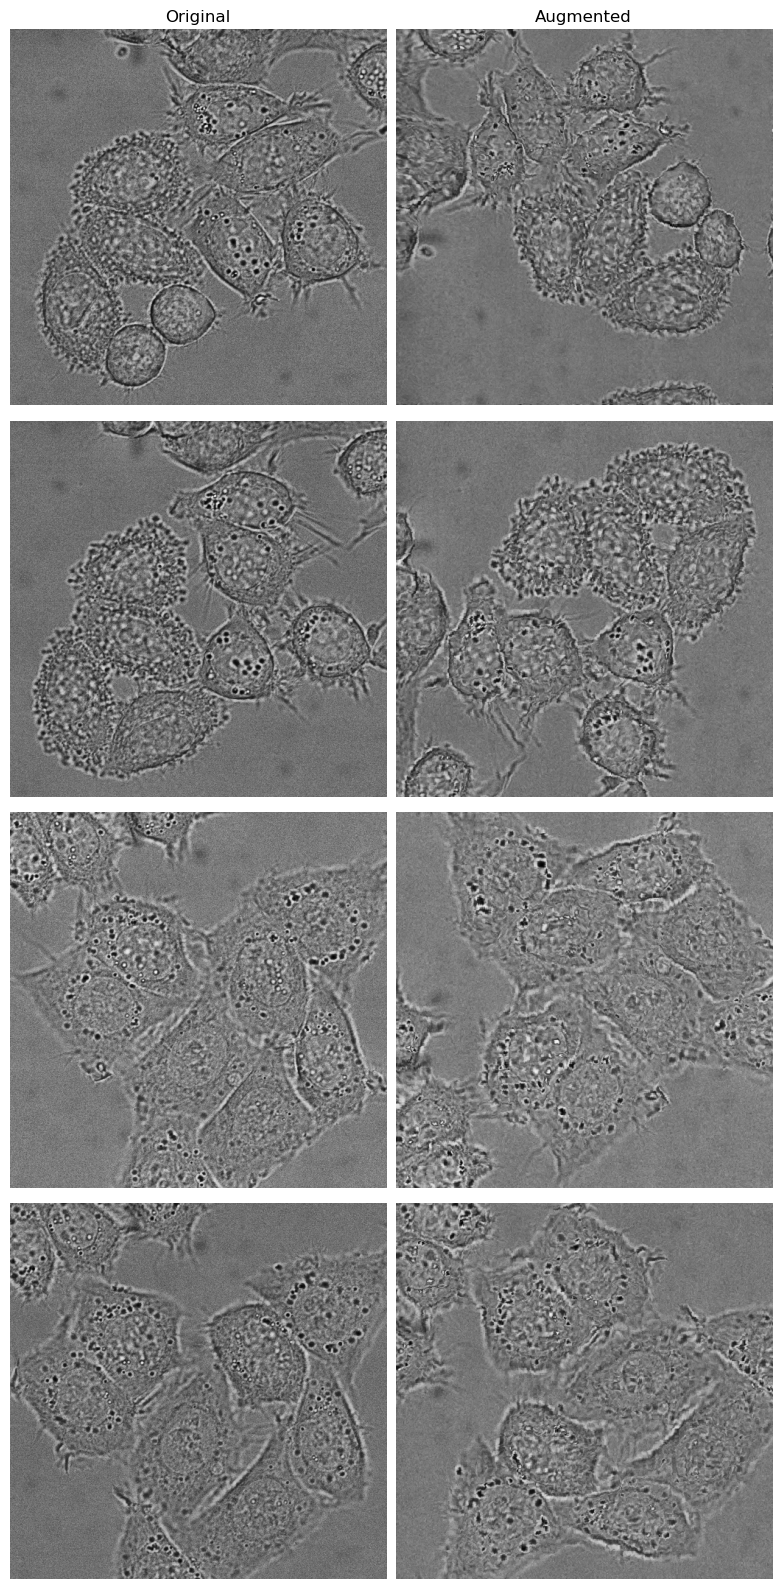

In [16]:
fig, axes = plt.subplots(len(example), 2, figsize=(8, 4 * len(example)))

axes[0,0].set_title("Original")
axes[0,1].set_title("Augmented")

reset_seed()
for row, (tmp_X, tmp_y, tmp_w) in zip(axes, example):
    row[0].imshow(min_max(tmp_X), cmap="gray")
    row[0].axis("off")
    row[1].imshow(min_max(pipeline(tf.expand_dims(tmp_X, 0),
                                   tf.expand_dims(tmp_y, 0),
                                   tf.expand_dims(tmp_w, 0))[0][0]), cmap="gray")
    row[1].axis("off")

fig.tight_layout()
plt.show()

# Main training loop

In [17]:
def train(helper, train_dataset, val_dataset=None, examples=None, epochs=100, ckpt_every=10, plot_every=1, verbose=True): # A helper function I wrote in a hurry.
    history = []
    ds_card = train_dataset.cardinality
    for epoch in range(1, epochs + 1):
        # Learning rate schedule
        if helper.opt_schedule is not None: 
            helper.optimizer.learning_rate = helper.opt_schedule(epoch)

        # Create progress bar
        if verbose: 
            print(f"\nEpoch {epoch}/{epochs}")
            progbar = tf.keras.utils.Progbar(target=ds_card)

        # Run the training steps
        for i, batch in enumerate(train_dataset):
            loss, acc = helper.dist_train_step(batch)
            # Update prog bar
            if verbose:
                progbar.update(i + 1, zip(['loss', 'acc'], [loss, acc]), finalize=False)

        # Run for the validation set (if any) and append to history
        if val_dataset is not None:
            val_loss, val_acc = 0.0, 0.0
            for j, batch in enumerate(val_dataset):
                vloss, vacc = helper.dist_val_step(batch)
                val_loss += vloss
                val_acc += vacc
            val_loss /= (j + 1)
            val_acc /= (j + 1)
            history.append([loss, acc, val_loss, val_acc])
            if verbose: progbar.update(i, zip(['loss', 'acc', 'val_loss', 'val_acc', 'lr'], 
                                              [loss, acc, val_loss, val_acc, helper.optimizer.learning_rate.numpy()]), finalize=True)
        else: 
            history.append([loss, acc])
            if verbose: progbar.update(i, zip(['loss', 'acc', 'lr'], [loss, acc, helper.optimizer.learning_rate.numpy()]), finalize=True)

        # Training checkpoint
        if type(ckpt_every) is int: 
            if epoch % ckpt_every == 0: 
                helper.checkpoint.save(helper.checkpoint_dir)

        # Plot training progression with the selected examples
        if type(plot_every) is int: 
            if epoch % plot_every == 0 and examples is not None:
                plt.close()
                X, y = list(examples.take(1))[0]
                image_list = [X.numpy()[0], y.numpy()[0], helper.model(X).numpy().argmax(axis=-1)[0]]
                image_list = [(255.0 * img).astype('uint8') if img.dtype !='uint8' else img for img in image_list]
                fig, ax = plt.subplots(1, 3, figsize=(12, 24))
                fig.suptitle(f"\nEpoch {epoch}/{epochs}", y=0.6)
                ax[0].set_title("Image")
                ax[1].set_title("Mask")
                ax[2].set_title("Predicted Mask")
                for k in range(3): 
                    ax[k].imshow(image_list[k], cmap="gray")
                    ax[k].axis("off")    
                fig.tight_layout()
                plt.show()
    return history

## Cross-validation

Nothing too fancy: GroupKFold with each of the recordings as a group

W0000 00:00:1754503513.981665 1224702 auto_shard.cc:553] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.
W0000 00:00:1754503514.089969 1224702 auto_shard.cc:553] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.
2025-08-06 15:05:20.643849: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
E0000 00:00:1754503530.117998 1224702 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1/u_net_1/spatial_dropout2d_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-08-06 15:06:02.925652: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceItera

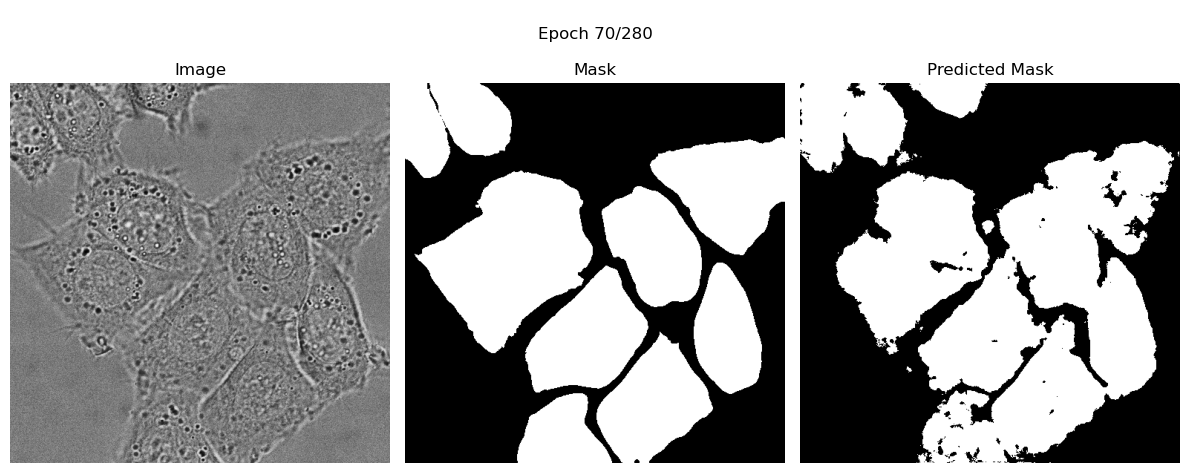

2025-08-06 15:39:22.270406: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


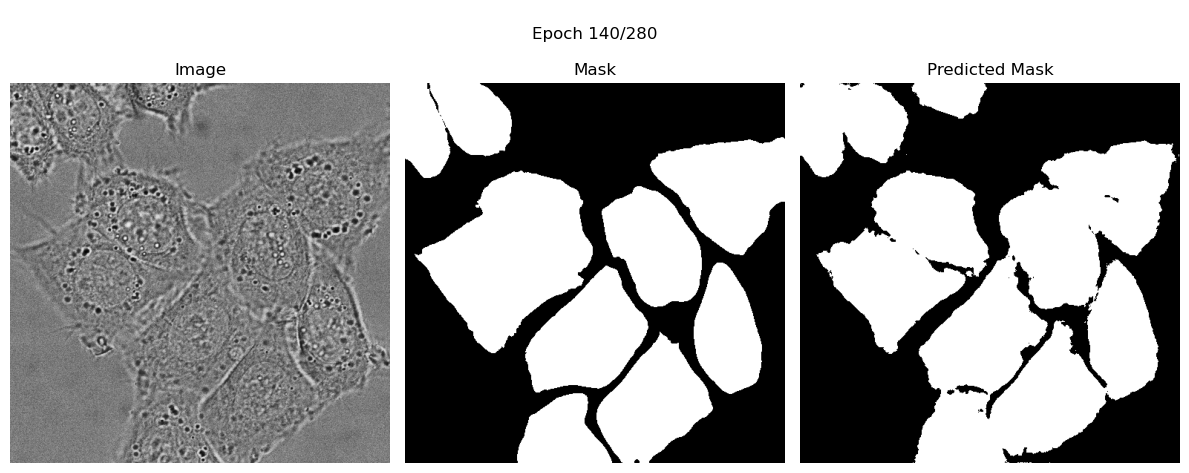

2025-08-06 16:13:34.808255: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


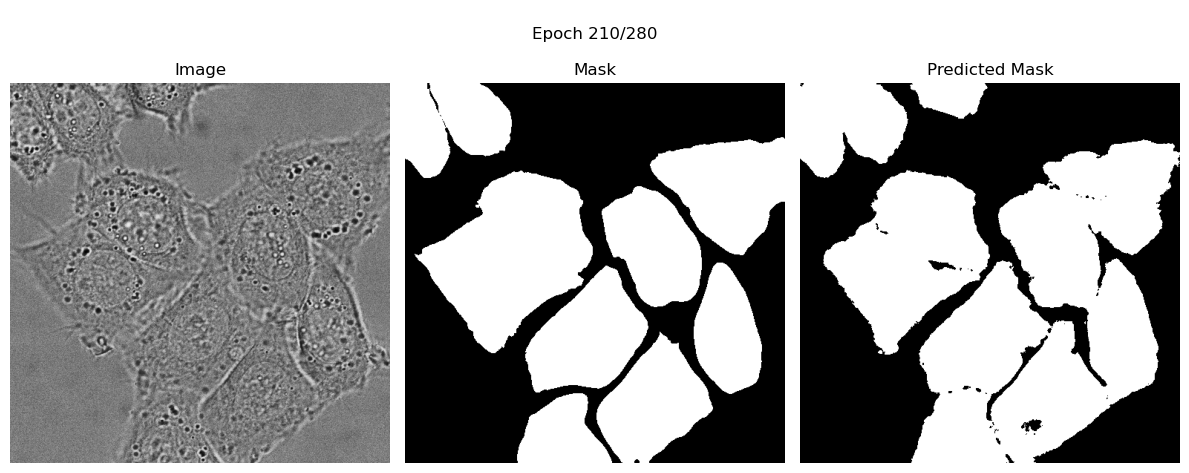

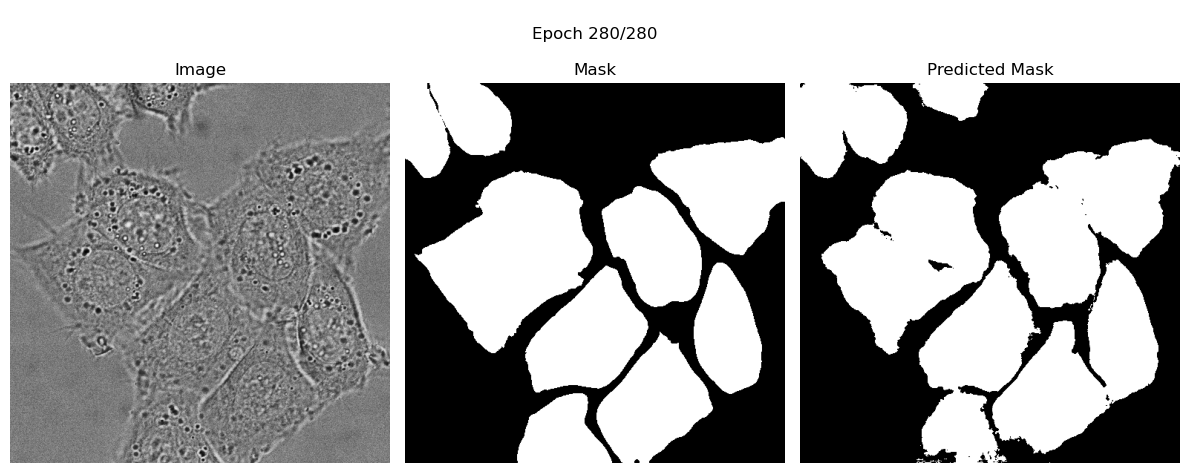

W0000 00:00:1754510363.847329 1224702 auto_shard.cc:553] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 520ms/step


W0000 00:00:1754510369.901146 1224702 auto_shard.cc:553] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.
W0000 00:00:1754510370.011863 1224702 auto_shard.cc:553] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.
E0000 00:00:1754510384.378800 1224702 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1/u_net_1/spatial_dropout2d_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-08-06 17:24:48.124949: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


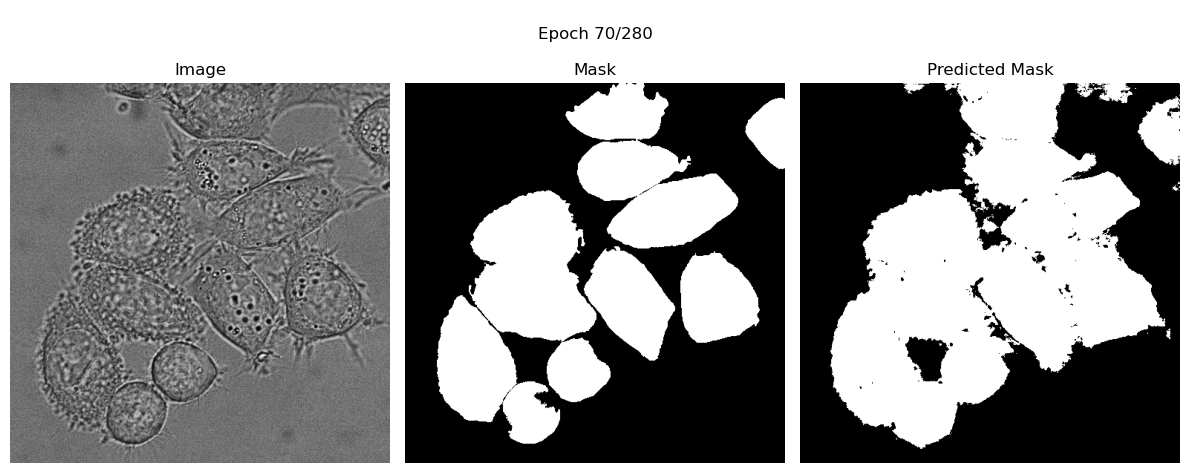

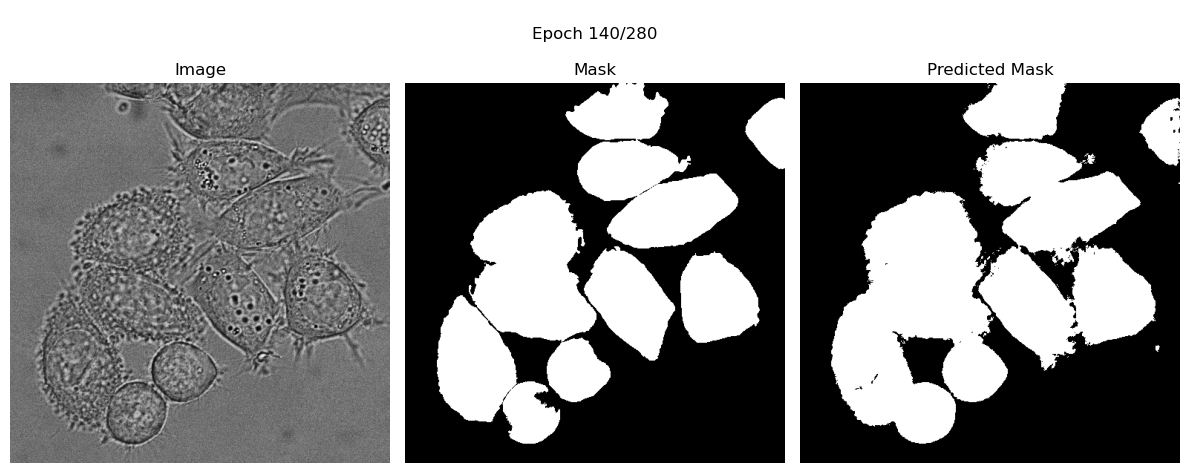

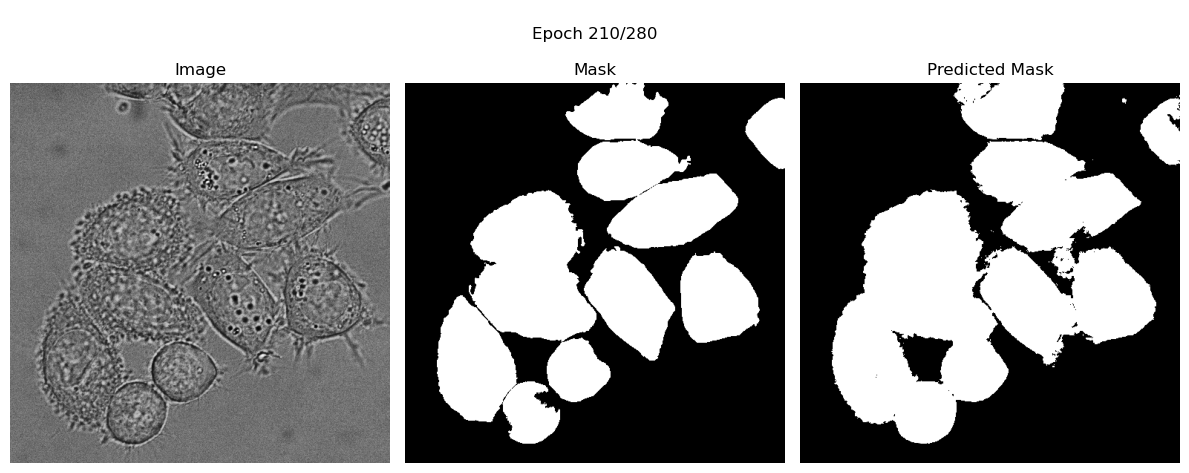

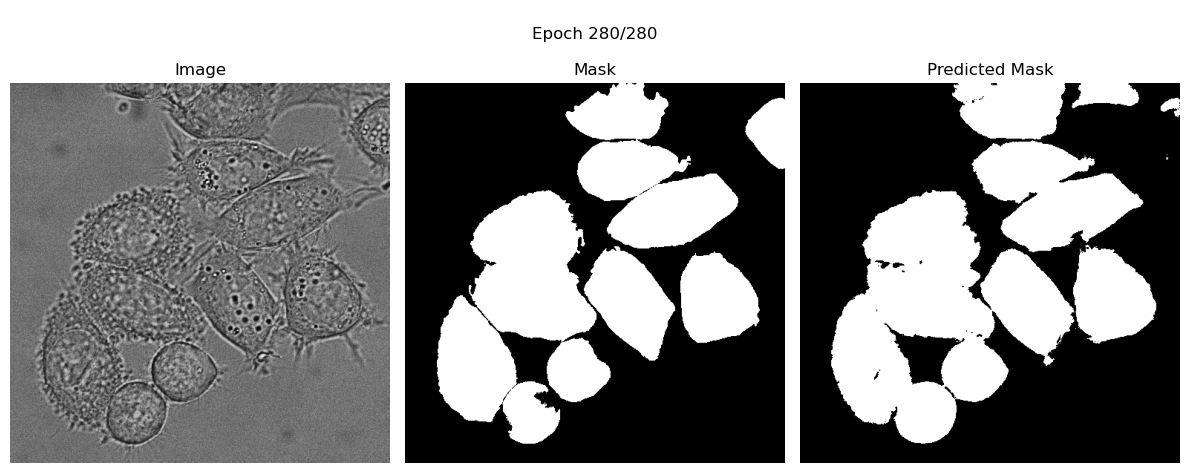

W0000 00:00:1754517342.527550 1224702 auto_shard.cc:553] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 538ms/step


In [18]:
max_lr = 1.E-3

lr_decay_start, lr_decay_rate, lr_decay_step = (2, 0.1, 3)

model_param = {"input_shape": img_shape,
               "dropout": 0.2}

oof_dice = []
oof_IoU = []

fold = [["01", "02"], ["02", "01"]]

for i in range(2):
    # In case we're running this cell over and over again when searching hyperparameters
    try:
        del helper
    except:
        pass

    # Restore the random seed and clear the current TF graph
    reset_seed()
    K.clear_session()

    # Set the augmentation, batching and distribution of the dataset.
    # The augmentation .map() should come after both the .batch() and .cache()
    # for increased variety of augmented samples.
    training_size = hela_train[fold[i][0]].cardinality().numpy()
    train_ds = hela_train[fold[i][0]].shuffle(training_size, reshuffle_each_iteration=True)\
                                     .repeat(np.lcm(batch_size, training_size) // (training_size))\
                                     .batch(batch_size, drop_remainder=False, num_parallel_calls=tf.data.AUTOTUNE)\
                                     .map(pipeline, num_parallel_calls=tf.data.AUTOTUNE)\
                                     .prefetch(tf.data.AUTOTUNE)
    dist_train = strategy.experimental_distribute_dataset(train_ds)

    # Same thing for the validation split
    validation_size = hela_train[fold[i][1]].cardinality().numpy()
    val_ds = hela_train[fold[i][1]].map(lambda X, y, sw: (X, y))\
                                   .cache()\
                                   .batch(2 * batch_size, drop_remainder=False, num_parallel_calls=tf.data.AUTOTUNE)
    dist_val = strategy.experimental_distribute_dataset(val_ds)

    # GPU training
    gc.collect()
    with strategy.scope():    
        gc.collect()
        helper = UNetHelper(strategy=strategy,
                            model_param=model_param,
                            loss_func=tf.keras.losses.sparse_categorical_crossentropy,
                            optimizer=tf.keras.optimizers.SGD(learning_rate=max_lr, momentum=0.99),
                            #opt_schedule=tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=[5,], values=[1e-2, 1e-3]),
                            )
        if train_model:
            train(helper, dist_train, dist_val, val_ds.rebatch(1), max_epochs, ckpt_every=60, plot_every=70, verbose=False)#, max_epochs, ckpt_every=60, plot_every=70)
            helper.model.save(f"{tf_dir}/models/model_fold{i + 1}.keras")
        else: 
            helper.model.load(f"{tf_dir}/models/model_fold{i + 1}.keras")

    # Out-of-fold results
    pred = helper.model.predict(val_ds.map(lambda X, y: X))
    oof_true = list(val_ds.map(lambda X, y: y).rebatch(validation_size).take(1))[0]
    oof_dice.append(dice_loss(oof_true, pred).numpy().mean())
    oof_IoU.append(IoU(oof_true, pred).numpy().mean())    

In [19]:
print("Average out-of-fold IoU: {:.6f}".format(np.mean(oof_IoU)))
print("Average out-of-fold dice loss: {:.6f}".format(np.mean(oof_dice)))

Average out-of-fold IoU: 0.866305
Average out-of-fold dice loss: 0.117310


## Training with the entire dataset

Same as before, but this time for the entire training dataset

In [20]:
try:
    del helper
except:
    pass

reset_seed()
K.clear_session()

train_ds = hela_train["01"].concatenate(hela_train["02"])
training_size = train_ds.cardinality()
train_ds = train_ds.shuffle(training_size, reshuffle_each_iteration=True)\
                   .repeat(2 * np.lcm(batch_size, training_size) // (training_size))\
                   .batch(batch_size, drop_remainder=False, num_parallel_calls=tf.data.AUTOTUNE)\
                   .map(pipeline, num_parallel_calls=tf.data.AUTOTUNE)\
                   .prefetch(tf.data.AUTOTUNE)
dist_train = strategy.experimental_distribute_dataset(train_ds)

gc.collect()
with strategy.scope():    
    gc.collect()
    helper = UNetHelper(strategy=strategy,
                        model_param=model_param,
                        loss_func=tf.keras.losses.sparse_categorical_crossentropy,
                        optimizer=tf.keras.optimizers.SGD(learning_rate=max_lr, momentum=0.99),
                        #opt_schedule=tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=[5,], values=[1e-2, 1e-3]),
                        )
    if train_model:
        train(helper, dist_train, None, None, max_epochs, ckpt_every=60, plot_every=None, verbose=True)
        helper.model.save(f"{tf_dir}/models/model_all.keras")
    else: 
        helper.model.load(f"{tf_dir}/models/model_all.keras")

W0000 00:00:1754517348.229259 1224702 auto_shard.cc:553] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.
W0000 00:00:1754517348.229466 1224702 auto_shard.cc:553] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1/280


E0000 00:00:1754517363.430979 1224702 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1/u_net_1/spatial_dropout2d_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


41/42 ━━━━━━━━━━━━━━━━━━━━ 49s 854ms/step - loss: 0.9481 - acc: 0.5292 - lr: 0.0010

Epoch 2/280
41/42 ━━━━━━━━━━━━━━━━━━━━ 40s 867ms/step - loss: 0.7280 - acc: 0.6288 - lr: 0.0010

Epoch 3/280
41/42 ━━━━━━━━━━━━━━━━━━━━ 40s 866ms/step - loss: 0.6237 - acc: 0.6713 - lr: 0.0010

Epoch 4/280
41/42 ━━━━━━━━━━━━━━━━━━━━ 40s 867ms/step - loss: 0.5539 - acc: 0.6978 - lr: 0.0010

Epoch 5/280
41/42 ━━━━━━━━━━━━━━━━━━━━ 40s 868ms/step - loss: 0.5128 - acc: 0.7214 - lr: 0.0010

Epoch 6/280
41/42 ━━━━━━━━━━━━━━━━━━━━ 40s 867ms/step - loss: 0.4663 - acc: 0.7398 - lr: 0.0010

Epoch 7/280
41/42 ━━━━━━━━━━━━━━━━━━━━ 40s 865ms/step - loss: 0.4941 - acc: 0.7531 - lr: 0.0010

Epoch 8/280
41/42 ━━━━━━━━━━━━━━━━━━━━ 40s 867ms/step - loss: 0.4688 - acc: 0.7627 - lr: 0.0010

Epoch 9/280
41/42 ━━━━━━━━━━━━━━━━━━━━ 40s 863ms/step - loss: 0.4832 - acc: 0.7706 - lr: 0.0010

Epoch 10/280
41/42 ━━━━━━━━━━━━━━━━━━━━ 40s 864ms/step - loss: 0.4444 - acc: 0.7768 - lr: 0.0010

Epoch 11/280
41/42 ━━━━━━━━━━━━━━━━━━━━ 4

2025-08-06 21:39:10.874871: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 241/280
41/42 ━━━━━━━━━━━━━━━━━━━━ 42s 891ms/step - loss: 0.2760 - acc: 0.9186 - lr: 0.0010

Epoch 242/280
41/42 ━━━━━━━━━━━━━━━━━━━━ 42s 893ms/step - loss: 0.2572 - acc: 0.9186 - lr: 0.0010

Epoch 243/280
41/42 ━━━━━━━━━━━━━━━━━━━━ 41s 890ms/step - loss: 0.2723 - acc: 0.9187 - lr: 0.0010

Epoch 244/280
41/42 ━━━━━━━━━━━━━━━━━━━━ 41s 891ms/step - loss: 0.2438 - acc: 0.9187 - lr: 0.0010

Epoch 245/280
41/42 ━━━━━━━━━━━━━━━━━━━━ 42s 890ms/step - loss: 0.1644 - acc: 0.9188 - lr: 0.0010

Epoch 246/280
41/42 ━━━━━━━━━━━━━━━━━━━━ 41s 888ms/step - loss: 0.2934 - acc: 0.9189 - lr: 0.0010

Epoch 247/280
41/42 ━━━━━━━━━━━━━━━━━━━━ 41s 890ms/step - loss: 0.2009 - acc: 0.9189 - lr: 0.0010

Epoch 248/280
41/42 ━━━━━━━━━━━━━━━━━━━━ 42s 892ms/step - loss: 0.1736 - acc: 0.9190 - lr: 0.0010

Epoch 249/280
41/42 ━━━━━━━━━━━━━━━━━━━━ 42s 890ms/step - loss: 0.3080 - acc: 0.9191 - lr: 0.0010

Epoch 250/280
41/42 ━━━━━━━━━━━━━━━━━━━━ 41s 888ms/step - loss: 0.2697 - acc: 0.9191 - lr: 0.0010

Epoch 251

# Predictions with the trained neural network

In [27]:
def process_test(img):
    clh = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clh_img = clh.apply(np.squeeze(img.numpy()))
    return tf.constant(np.expand_dims(clh_img / 255.0, -1), dtype=tf.float32, shape=img.get_shape())

## Create movies using the training dataset

In [28]:
os.system(f"mkdir -p figures")

0

In [29]:
pred_train = tfds.load("hela_train", data_dir=tf_dir)

In [30]:
def make_movie(model, ds):
    movie_arr = np.zeros((ds.cardinality().numpy(), img_shape[0], img_shape[1] * 2), dtype="uint8")
    for i, sample in enumerate(ds.map(lambda x: x["image"])):
        tmp = tf.expand_dims(process_test(sample), 0)
        pred = (model.predict(tmp, verbose=0).argmax(axis=-1)[0] * 255.0).astype("uint8")
        movie_arr[i] = np.hstack((sample[...,0].numpy(), pred))
    return [Image.fromarray(frame) for frame in movie_arr]

In [43]:
# Segment #01
movie = make_movie(helper.model, pred_train["01"])
movie[0].save(f"figures/train01.gif", save_all=True, append_images=movie[1:], duration=1000. / 60, loop=0)

In [44]:
# Segment #02
movie = make_movie(helper.model, pred_train["02"])
movie[0].save(f"figures/train02.gif", save_all=True, append_images=movie[1:], duration=1000. / 60, loop=0)

## Write the test predictions to dir

Use the CTC format (16-bit with labeled cells)

In [ ]:
os.system("mkdir -p DIC-C2DH-HeLa/01_RES DIC-C2DH-HeLa/02")

0

In [34]:
hela_test = tfds.load("hela_test", data_dir=tf_dir)

In [ ]:
hela_sub = hela_test['01'].map(lambda pair: tf.py_function(process_test, inp=[pair['image']], Tout=[tf.float32]),  
                               num_parallel_calls=tf.data.AUTOTUNE)\
                          .map(lambda X: tf.ensure_shape(X, img_shape))\
                          .batch(2 * batch_size, num_parallel_calls=tf.data.AUTOTUNE)

sub_pred = helper.model.predict(hela_sub).argmax(axis=-1)

for i in range(sub_pred.shape[0]):
    img = (sub_pred[i] * 255.0).astype("uint8")
    labeled_img = label(img).astype("uint16")
    cv.imwrite(f"DIC-C2DH-HeLa/01_RES/mask{str(i).zfill(3)}.tif", labeled_img)

W0000 00:00:1754531603.773115 1224702 auto_shard.cc:553] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 556ms/step


In [ ]:
hela_sub = hela_test['02'].map(lambda pair: tf.py_function(process_test, inp=[pair['image']], Tout=[tf.float32]),  
                               num_parallel_calls=tf.data.AUTOTUNE)\
                          .map(lambda X: tf.ensure_shape(X, img_shape))\
                          .batch(2 * batch_size, num_parallel_calls=tf.data.AUTOTUNE)

sub_pred = helper.model.predict(hela_sub).argmax(axis=-1)

for i in range(sub_pred.shape[0]):
    img = (sub_pred[i] * 255.0).astype("uint8")
    labeled_img = label(img).astype("uint16")
    cv.imwrite(f"DIC-C2DH-HeLa/02_RES/mask{str(i).zfill(3)}.tif", labeled_img)

W0000 00:00:1754531610.980999 1224702 auto_shard.cc:553] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 402ms/step


In [37]:
# https://www.youtube.com/watch?v=dQw4w9WgXcQ